# Theoretical Computer Sciences Project

#### Sergio Peignier and Théotime Grohens

\section{1 - Graph Therory}

In [1]:
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math 

\subsection{1.1 Introduction}

In this project we will apply graph algorithms to study the gene regulatory network (GRN)
of \textit{Saccharomyces cerevisiae}.
This species of yeast, it is a small single-cell eukaryote, with a short generation time, and
two possible forms: an haploid one and a diploid one. Moreover, this organism can be easily
cultured, and it has an important economic impact since it is extensively used for instance,
in winemaking, baking, and brewing. Due to these characteristics, Saccharomyces cerevisiae
is studied as an important model organism.

In this work we will study the \textbf{gene regulatory network} of \textit{Saccharomyces cerevisiae }, using graph theory algorithms. The files that are provided for this project have been used in [MCK+12] , as gold-standards to assess gene regulatory network inference algorithms, and they are the result of biological experiments based on ChIP binding data [MWG + 06], and systematic transcription factor deletions [HKI07]. Hereafter we describe each dataset in details:

\begin{itemize}
\item GRN_edges_S_cerevisiae.txt : contains the edges of the \textit{ S. cervisiae} regulatory network (from transcription factors to target genes). The intended meaning is that if there is an edge between transcription factor X and the target gene A, then X regulates the transcription of A ;

\item net4_transcription_factors.tsv : Is a file containing in a single column the identifiers of the transcription factors of \textit{S. cervisiae} that were studied ;

\item net4_gene_ids.tsv : The two previous files, use specific identifiers to denote genes, and this file contains the gene name associated to each gene identifier ;

\item go_slim_mapping.tab.txt : Only columns 0 and 5 will be used in this work. Column 0 contains the gene name, and column 5 contains its Gene Ontology (GO) annotation (http://www.geneontology.org/). Notice that two different rows may give for the same gene different Gene Ontology annotations. 
\end{itemize}

\subsection{1.2 Exercices}

### \textbf{Exercise 1 : } Exploration and characterization of the gene regulatory network

#### 1) Load the dataset and create a NetworkX graph instance.

On importe les datasets avec pandas : 

In [ ]:
GRN_edges_SC = pd.read_csv("./datas/GRN_edges_S_cerevisiae.txt", sep = ',',  header=0)
net4_transcription_factors = pd.read_csv("./datas/net4_transcription_factors.tsv", sep = '\n',  header=0) 
net4_gene_ids = pd.read_csv("./datas/net4_gene_ids.tsv", sep = '\t', header=0) 
go_slim_mappingtab = pd.read_csv("./datas/go_slim_mapping.tab.txt", sep = '\t', header=None) 

On vérifie que tout a bien été importé 

In [ ]:
GRN_edges_SC = GRN_edges_SC.iloc[:,1:]

In [ ]:
# on peut transformer le df en array (au cas où si besoin)
GRN_edges_SC_np = GRN_edges_SC.to_numpy()

In [ ]:
net4_gene_ids.head()

In [ ]:
net4_transcription_factors.head()

In [ ]:
go_slim_mappingtab.head()

In [ ]:
GRN_edges_SC.head()

Le dataset a bien été importé, on créé donc un graphe $G = <V,E>$ dont l'ensemble des noeuds noté $V$ contient les facteurs de transcription et les gènes cibles et l'ensemble des arettes noté $E$ représente les régulations des gènes par les facteurs de transcription.

In [ ]:
G = nx.from_pandas_edgelist(GRN_edges_SC, "transcription_factor", "target_gene")

#### 2) Plot the gene regulatory network,  the plot should be readable,  understandable,  andinformative.  Which information did you decide to convey in your plot?  Why?

On représente le graphe G tel quel.

In [ ]:
#Premiere impression pour le graphe 
plt.figure(figsize=(15,8))
nx.draw(G, node_size = 12)

In [ ]:
#On transforme G en graphe dirigé (pas super utile et prend bcp de temps à charger)
#G = nx.DiGraph(G)

In [ ]:
#On rend le graphe plus lisible 
plt.figure(figsize=(18,10))
pos = nx.spring_layout(G, k = 0.6,) #return the relative positions of the nodes,k = optimal distance between nodes
nx.draw(G, node_size = 18, 
        pos = pos, 
        width = 0.4, 
        node_color = 'cyan',
        edge_color = 'DarkSlateGray')

Le graphe n'est pas lisible tel quel et ne donne aucune information sur la nature des données.\\

L'ensemble $V$ peut être séparé en deux sous-ensembles :
\begin{itemize}
    \item $X$ : ensemble des facteurs de transcription ;
    \item $A$ : ensemble des gènes.
\end{itemize}
Il serait donc plus isdjocospjdkpl de représenter les deux sous-ensembles $X$ et $A$ de façon distincte. 

##### Graphe bipartite :

In [ ]:
from networkx.algorithms import bipartite

In [ ]:
g = nx.Graph()

In [ ]:
g.add_nodes_from(GRN_edges_SC['transcription_factor'], bipartite = 'transcription_factor')

In [ ]:
g.add_nodes_from(GRN_edges_SC['target_gene'], bipartite = 'target_gene')

In [ ]:
g.add_edges_from(zip(GRN_edges_SC['transcription_factor'], GRN_edges_SC['target_gene']))

In [ ]:
#tf = transcription_factor
tf_nodes = [ n for n in g.nodes() if g.nodes[n]
            ['bipartite'] == 'transcription_factor']

In [ ]:
# gn = gene = target_gene
gn_nodes = [ n for n in g.nodes() if g.nodes[n]
           ['bipartite'] == 'target_gene']

In [ ]:
pos_ = nx.bipartite_layout(g, tf_nodes, scale = 1)

Sur le graphe si-dessous, on réprésente la bipartie du graphe avec :
    \begin{itemize}
        \item À gauche les noeuds représentant les facteurs de transcription;
        \item À droite les noeuds représentant les gène cible pour une régulation.
    \end{itemize}
Globalement (sur une vue d'ensemble) on remarque tout de suite que certain facteurs agissent sur un plus grand nombre de gène cibles que d'autres.

In [ ]:
plt.figure(figsize=(30,20))
nx.draw(g, pos = pos_, node_size = 14,
       node_color = 'forestgreen',
       edge_color = 'darkblue',
       width = 0.1)

#### 3) Describe the network by computing pertinent local and global metrics,  explain your choices, represent the results graphically if necessary, and interpret the results.

Clustering coeff : en fait ça sert à R je crois vu kon a un bipartire

In [ ]:
tf_clust = nx.clustering(G, tf_nodes)
gn_clust = nx.clustering(G, gn_nodes)
clustering = [[k for k in tf_clust.values()], [k for k in gn_clust.values()]]

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Clustering Coefficient",fontsize=20)
plt.ylabel("Nodes",fontsize=20)
plt.title("Histogram of clustering coefficients", fontsize=20)

x1 = clustering[1]
x2 = clustering[0]
plt.hist([x1, x2], color = ['coral', 'mediumorchid'], 
         edgecolor = 'black', label = ["gene's nodes", "TGF's nodes"])

plt.legend()
plt.show()

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Clustering Coefficient",fontsize=20)
plt.ylabel("Nodes",fontsize=20)
plt.title("Histogram of clustering coefficients", fontsize=20)

x1 = clustering[1]
plt.hist(x1, color = ['coral'], 
         edgecolor = 'black', label = ["gene's nodes"])

plt.legend()
plt.show() 

In [ ]:
 sns.set_style("whitegrid")

plt.figure(figsize=(18,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Clustering Coefficient",fontsize=20)
plt.ylabel("Nodes",fontsize=20)
plt.title("Histogram of clustering coefficients", fontsize=20)

x2 = clustering[0]
plt.hist(x2, color = ['blue'], 
         edgecolor = 'black', label = ["TGF's nodes"])

plt.legend()
plt.show()

In [ ]:
plt.hist(clustering[1], alpha=0.6)
plt.hist(clustering[0], alpha=0.6)
plt.show()

In [ ]:
print(np.mean(clustering[0]))
print(np.mean(clustering[1]))

In [ ]:
nx.average_clustering(G)

In [ ]:
def overlap (G):
    out = []
    for couple in nx.utils.pairwise(G.nodes()):
        n = 0
        for nei in G[couple[0]]:
            if nei in G[couple[1]]:
                n+=1
        if n == 0:
            O = 0
        elif  G.degree(couple[0]) <= 1 or G.degree(couple[1]) <= 1:
            O = 0
        elif (G.degree(couple[0])-1+G.degree(couple[1])-1-n) == 0:
            print(G.degree(couple[0]),G.degree(couple[1]),n)
            O=100
        else :
            O =  n/(G.degree(couple[0])-1+G.degree(couple[1])-1-n)
        out.append((couple, O))
    return out

In [ ]:
overlap(G)

In [ ]:
nx.closeness_centrality(G) # inverse de la dist moyenne entre n et les autre noeuds

In [ ]:
nx.betweenness_centrality(G) # fraction of shortest paths that passes through n

In [ ]:
nx.density(G)

In [ ]:
RC = nx.rich_club_coefficient(G)

In [ ]:
lists = sorted(RC.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("Degree k",fontsize=10)
plt.ylabel("Rich Club Coefficient",fontsize=10)
plt.show()

In [ ]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

In [ ]:
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees, degree_freq) 
plt.xlabel('Degree')
plt.ylabel('Frequency')

#### 4) Implement and apply the k-shell decomposition algorithm.

We can first try to make a k-shell with a function \textit{'k_shell'} directly implemented in the networkx.algorithms.core library, for different $k$.

In [ ]:
from networkx.algorithms.core import k_shell

In [ ]:
nx.draw(nx.k_shell(G, k=2), node_size = 10)

In [ ]:
nx.draw(k_shell(G, k=4), node_size = 10)

In [ ]:
nx.draw(k_shell(G, k=6), node_size = 10)

In [ ]:
nx.draw(k_shell(G, k=7), node_size = 10)

For $k > 7$ there is no more node left.

Yet we try to implement ourself the \textit{k_shell} fonction.

In [ ]:
def my_kshell (G, k) :
    degrees = []
    GG = nx.Graph()
    GG.add_nodes_from(g)
    GG.add_edges_from(g.edges)
    
    ik = 1
    for ik in range(k):
        done = False
        while not done :
            rm = []
            for n in GG.nodes():
                if GG.degree(n)<=ik:
                    rm.append(n)
            for m in rm:
                GG.remove_node(m)
            done = True
            for n in GG.nodes():
                if GG.degree(n)<=ik:
                    done = False
                    break
            
    return GG

In [ ]:
new_G = my_kshell(G, 7)

In [ ]:
nx.draw(new_G, node_size = 10)

#### 5) For at least 4 of the metrics that you have used:  what is the time complexity of the algorithm that calculates it (explain)?

### \textbf{Exercise 2 : } Community detection

#### 1) You can choose between the Girvan Newman method and the Louvain algorithm tofind communities in the graph. Describe both algorithms, and their time complexities (explain).

#### The Girvan Newman method :

We can express Girvan-Newman algorithm in the following procedure:
\begin{enumerate}
    \item Calculate edge betweenness for every edge in the graph ;
    \item Remove the edge with highest edge betweenness ;
    \item Calculate edge betweenness for remaining edges ;
    \item Repeat steps 2–4 until all edges are removed.
\end{enumerate}

In its simplest and fastest form - worst-case time $O(E^{2}V$) on a network with $E$ edges and $V$ vertices, or $O(E^{3})$ on a sparse graph (where $V = E$).


#### The Louvain algorithm :

#### 2) Which algorithm did you choose, why ?

#### 3) For the the Girvan Newman method, the user should select one of the output partitions, explain the criterion that could be used to make this choice, and its complexity.

#### 4) Study the GO composition of each community.  To do this you can produce a countingmatrix $M$,  such  that $M_{i,j}$ is  the  number  of  genes  from  community $j$ that  have  GO annotation $i^1$.

#### 5) Is there a relationship between graph communities and particular cell functions ?

\section{Around the Traveling Salesman Problem}
    \subsection{Introduction}
#### Exact solution

In a complete graph, every node is adjacent to every other node. Therefore, if we take all the nodes in a complete graph in any order, there will be a path through those nodes in that order. (Then, if we join either end of that path, it will give us a Hamilton path.) ?

Let's define an Hamiltonian path $(n_0, n_1, n_2,...,n_n)$ in a complete graph of size $n$. There are $n$ possible starting nodes $n_0$. Then, as one of the $n$ nodes has already been visited, only $n-1$ options are left for $n_1$, $n-2$ for $n_2$ and so on until there is only one node left unvisited : $n_n$. Thus, there are $n\times n-1 \times n-2 \times ... \times 1 = n!$ distinct Hamiltonian paths in a complete graph of size $n$.


In fact, not all these path possibilities are different. On any such cycle, there are:
\begin{itemize}
    \item $n$ differents nodes where you can start the path ;
    \item The path is reversible, you can travel it through $2$ directions.
\end{itemize}

So any one of these $n!$ possible paths is in a set of $2n$ cycles which all contain the same set of edges.
So finaly get $\frac{n!}{2n} = \frac{(n-1)!}{2}$ distinct Hamilton paths



In [39]:
# Our complet graph (just a test for folowing algorithms)

Gc = nx.Graph()
Gc = nx.complete_graph(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
list(Gc.nodes())

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [44]:
def add_weight(G) :
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = random.randrange(0,10)+1
        #print(e, Gc[e[0]][e[1]]['weight'])

In [46]:
def draw_weight(G):
    wwidth = [d['weight'] for (u, v, d) in G.edges(data=True)]

    pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos)

    # edges
    nx.draw_networkx_edges(G, pos, width=wwidth)


    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    plt.axis("off")
    plt.show()


In [45]:
add_weight(Gc)

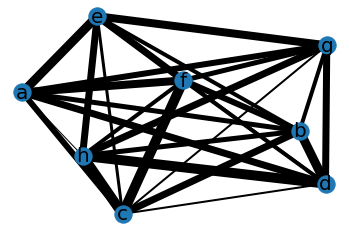

In [51]:
draw_weight(Gc)

In [4]:
def hamilton(G, pt):
    #pt : starting point
    F = [(G,[list(G.nodes())[pt]])]
    n = G.number_of_nodes()
    while F:
        graph,path = F.pop()
        temp = []
        neighbors = (node for node in graph.neighbors(path[-1]) if node != path[-1]) #exclude self loops
        for neighbor in neighbors:
            cppath = path + [] 
            cppath.append(neighbor)
            cpgraph = nx.Graph(graph)
            cpgraph.remove_node(path[-1])
            temp.append((cpgraph, cppath))
        for g,p in temp:
            if len(p) == n:
                return (p)
            else:
                F.append((g,p))

In [5]:
hamilton(Gc, 1)

['b', 'h', 'g', 'f', 'e', 'd', 'c', 'a']

In [6]:
Gtest = nx.petersen_graph()

In [48]:
add_weight(Gtest)

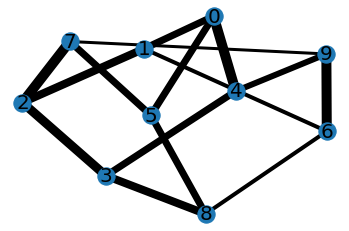

In [49]:
draw_weight(Gtest)

In [8]:
def succ(G, si, pred) : # returns successors of si that are not in pred
 
    si_succ_init = [s for s in G[si]]
    si_succ = []
    
    for sj in si_succ_init :
        if sj not in pred :
            si_succ.append(sj)
            
    return si_succ

In [92]:
def next_step(G, si, pred, path, weight, path_weight) :
    if len(pred)>0 :
        sp = pred[len(pred)-1]
        si_w = G[sp][si]['weight']
        weight = weight + si_w
    pred = pred + [si] # si is added to the predecessor list
    si_succ = succ(G, si, pred) # successors of si that are not in pred
    
    for sj in si_succ :
        next_step(G, sj, pred, path, weight, path_weight)
    
    # when each branch has been visited as deep as possible, the list of predecessor is added to path
    if len(si_succ) == 0 :
        path.append(pred)
        path_weight.append((pred, weight))
    
    return None

In [93]:
def find_path(G, s0) :
    pred = []   
    si = s0
    path = []
    path_weight = []
    weight = 0
    
    next_step(G, s0, pred, path, weight, path_weight)
        
    return path_weight

In [94]:
def Hamiltonian_path(G, s0) :
    # filters out all paths that passes through less nodes than n, with n the number of nodes in G
    
    n = len(G.nodes())
    path = find_path(G, s0)
    ham_path = []
    
    for tup in path :
        if len(tup[0]) >= n :
            ham_path.append(tup)
            
    return ham_path

In [95]:
Hamiltonian_path(Gtest, 1)

[([1, 0, 4, 3, 2, 7, 5, 8, 6, 9], 71),
 ([1, 0, 4, 3, 2, 7, 9, 6, 8, 5], 67),
 ([1, 0, 4, 9, 6, 8, 3, 2, 7, 5], 71),
 ([1, 0, 4, 9, 6, 8, 5, 7, 2, 3], 70),
 ([1, 0, 5, 7, 2, 3, 4, 9, 6, 8], 67),
 ([1, 0, 5, 7, 2, 3, 8, 6, 9, 4], 68),
 ([1, 0, 5, 8, 6, 9, 4, 3, 2, 7], 67),
 ([1, 0, 5, 8, 6, 9, 7, 2, 3, 4], 64),
 ([1, 2, 3, 4, 0, 5, 7, 9, 6, 8], 65),
 ([1, 2, 3, 4, 0, 5, 8, 6, 9, 7], 65),
 ([1, 2, 3, 8, 6, 9, 4, 0, 5, 7], 69),
 ([1, 2, 3, 8, 6, 9, 7, 5, 0, 4], 66),
 ([1, 2, 7, 5, 0, 4, 3, 8, 6, 9], 71),
 ([1, 2, 7, 5, 0, 4, 9, 6, 8, 3], 70),
 ([1, 2, 7, 9, 6, 8, 3, 4, 0, 5], 67),
 ([1, 2, 7, 9, 6, 8, 5, 0, 4, 3], 66),
 ([1, 6, 8, 3, 2, 7, 5, 0, 4, 9], 65),
 ([1, 6, 8, 3, 2, 7, 9, 4, 0, 5], 61),
 ([1, 6, 8, 5, 0, 4, 3, 2, 7, 9], 61),
 ([1, 6, 8, 5, 0, 4, 9, 7, 2, 3], 60),
 ([1, 6, 9, 4, 0, 5, 7, 2, 3, 8], 71),
 ([1, 6, 9, 4, 0, 5, 8, 3, 2, 7], 71),
 ([1, 6, 9, 7, 2, 3, 4, 0, 5, 8], 67),
 ([1, 6, 9, 7, 2, 3, 8, 5, 0, 4], 68)]

In [96]:
Gc_path = Hamiltonian_path(Gc, 'a')
Gc_path

[(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'], 36),
 (['a', 'b', 'c', 'd', 'e', 'f', 'h', 'g'], 35),
 (['a', 'b', 'c', 'd', 'e', 'g', 'f', 'h'], 34),
 (['a', 'b', 'c', 'd', 'e', 'g', 'h', 'f'], 36),
 (['a', 'b', 'c', 'd', 'e', 'h', 'f', 'g'], 33),
 (['a', 'b', 'c', 'd', 'e', 'h', 'g', 'f'], 36),
 (['a', 'b', 'c', 'd', 'f', 'e', 'g', 'h'], 40),
 (['a', 'b', 'c', 'd', 'f', 'e', 'h', 'g'], 39),
 (['a', 'b', 'c', 'd', 'f', 'g', 'e', 'h'], 38),
 (['a', 'b', 'c', 'd', 'f', 'g', 'h', 'e'], 37),
 (['a', 'b', 'c', 'd', 'f', 'h', 'e', 'g'], 37),
 (['a', 'b', 'c', 'd', 'f', 'h', 'g', 'e'], 37),
 (['a', 'b', 'c', 'd', 'g', 'e', 'f', 'h'], 40),
 (['a', 'b', 'c', 'd', 'g', 'e', 'h', 'f'], 40),
 (['a', 'b', 'c', 'd', 'g', 'f', 'e', 'h'], 40),
 (['a', 'b', 'c', 'd', 'g', 'f', 'h', 'e'], 37),
 (['a', 'b', 'c', 'd', 'g', 'h', 'e', 'f'], 42),
 (['a', 'b', 'c', 'd', 'g', 'h', 'f', 'e'], 39),
 (['a', 'b', 'c', 'd', 'h', 'e', 'f', 'g'], 43),
 (['a', 'b', 'c', 'd', 'h', 'e', 'g', 'f'], 44),
 (['a', 'b', 'c', 'd

In [21]:
N_Gc_path = len(Gc_path)
n = len(Gc.nodes())
print(N_Gc_path == math.factorial(n-1)) 

True


As we showed before, we can find $n!$ Hamiltonian paths in a complete graph of size $n$. Here we know the starting node $n_1$ so we don't have the $n$ options for $n_1$ but only one, so we end up with $\frac{n!}{n} = (n-1)!$ Hamiltonian paths.

In [114]:
def shortest_ham_path(G, s0) :
    path_w = Hamiltonian_path(G, s0)
    w_min = path_w[0][1]
    path_min = []
    
    for tup in path_w :
        if tup[1] < w_min :
            w_min = tup[1]
            path_min = [tup]
        elif tup[1] == w_min :
            path_min.append(tup)
            
    return path_min
    

In [115]:
Gc_min_path = shortest_ham_path(Gc, 'a')
Gtest_min_path = shortest_ham_path(Gtest, 1)

In [116]:
print('Gc_min_path', Gc_min_path)
print('Gtest_min_path', Gtest_min_path)

Gc_min_path [(['a', 'h', 'f', 'd', 'c', 'g', 'b', 'e'], 21), (['a', 'h', 'f', 'd', 'e', 'c', 'g', 'b'], 21), (['a', 'h', 'f', 'g', 'c', 'd', 'e', 'b'], 21)]
Gtest_min_path [([1, 6, 8, 5, 0, 4, 9, 7, 2, 3], 60)]
